# Pairs trading


In pairs trading, the quantity we are examining is the distance between two securities, which we expect to revert back to its mean. For this to be a reasonable assumption, we need the two securities to be statistically cointegrated. In practice, two companies whose products are substitutes for each other are often cointegrated. That is, they generally move together due to shifts in the market and in their specific industry, and move little relative to each other.

How do we incorporate the prediction about their difference into our portfolio? Suppose we are looking at two securities X and Y. Then we go long in X and short in Y when the two are closer together than expected, and short in X and long in Y when the two are far apart. In this way we remain neutral to the market, industry, and other shifts that cause X and Y to move together, while making money on their difference reverting to the mean. We can quantify "closer than expected" as the difference having a z-score of less than -1, and "farther apart than expected" as a z-score greater than 1. This is easier to picture if X's price is higher than Y's, but the end result is the same in either case.

Using the coint function from statsmodels, let's check whether HP and Microsoft stock prices are cointegrated.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as wb
%matplotlib inline 

In [3]:
from statsmodels.tsa.stattools import coint
start = '2012-01-01'
end = '2016-12-31'

In [5]:
X = wb.DataReader('MSFT','yahoo',start,end)['Adj Close']
Y = wb.DataReader('HP','yahoo',start,end)['Adj Close']

In [9]:
# Compute the p-value for the cointegration of the two series
_,pvalue, _ = coint(X,Y)
print (pvalue)

0.9636404282131023


The p-value is low, so the two series are cointegrated. Next we need to find the mean of the difference. We'll compute the cumulative moving average - that is, the average of all the values up to each day - as though we were looking at the data every day without knowing the future.

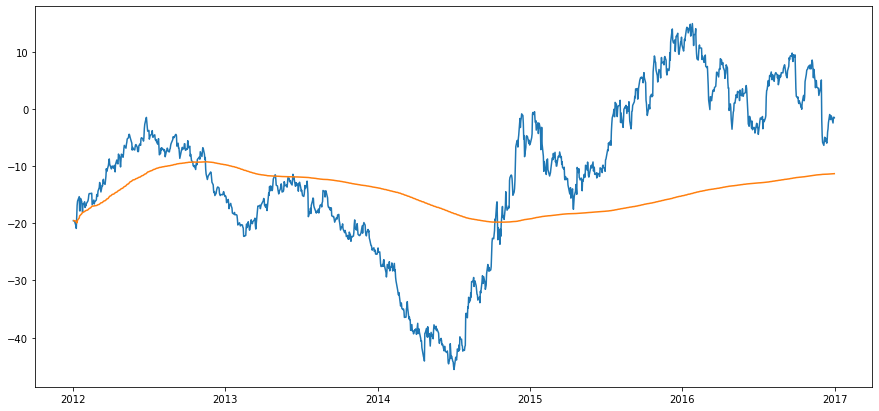

In [10]:
# Plot their difference and the cumulative moving average of their difference
val = pd.DataFrame(index = X.index, columns=['diff','mu'])
val['diff'] = X - Y
val['mu']= [val['diff'][:i].mean() for i in range(len(val['diff']))]
plt.figure(figsize=(15,7))
plt.plot(val['diff'])
plt.plot(val['mu'])
plt.show()

In some cases, we may instead want our mean to refer only to the moving average, excluding data from too long ago. Below we can see the difference between the cumulative moving average and the 60-day running average.

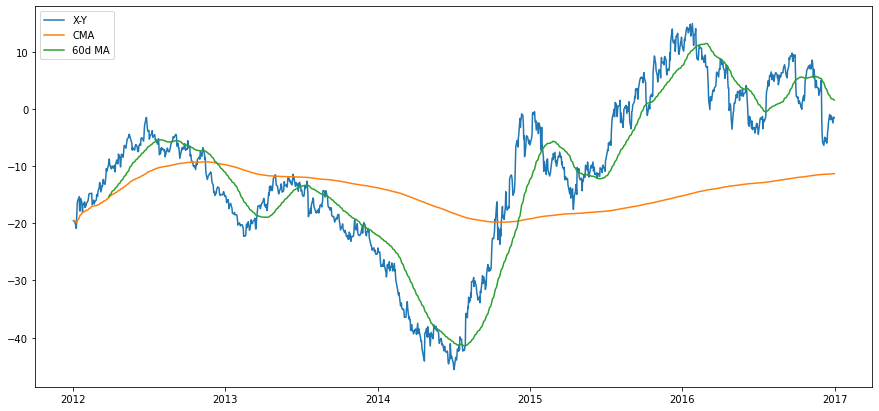

In [15]:
mu_60d = val['diff'].rolling(60).mean()
plt.figure(figsize=(15,7))
plt.plot(val['diff'], label='X-Y')
plt.plot(val['mu'], label='CMA')
plt.plot(mu_60d, label='60d MA')
plt.legend();

From here our trading strategy is identical to that for a single security, where we replace the asset with the spread X-Y. When we short the spread, we buy Y and sell X, and vice versa for going long. We'll be using the CMA for the mean, but you can easily change it to see the difference. Keep in mind, however, that what works well with this data may not be suited for other situations, and each definition of the mean will sometimes outperform the other.

In [19]:
# Compute the z-score of the difference on each day
zscores = [(val['diff'][i] - val['mu'][i]) / np.std(val['diff'][:i]) for i in range(len(val['diff']))]

# Start with no money and no positions
money = 0
count = 0
for i in range(len(val['diff'])):
    # Sell short if the z-score is > 1
    if zscores[i] > 1:
        money += val['diff'][i]
        count -= 1
    # Buy long if the z-score is < 1
    elif zscores[i] < -1:
        money -= val['diff'][i]
        count += 1
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscores[i]) < 0.5:
        money += count*val['diff'][i]
        count = 0
        
print (money)

6007.3216762542725


<ipython-input-19-38831e8410bb>:2: RuntimeWarning: divide by zero encountered in double_scalars
  zscores = [(val['diff'][i] - val['mu'][i]) / np.std(val['diff'][:i]) for i in range(len(val['diff']))]
